# EDA for VinBigData Chest X-Ray challenge

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
INPUT_FOLDER = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection"
INPUT_FOLDER_PNG = "/kaggle/input/vinbigdata-chest-xray-original-png"

## Load data and check some basic counts

### Count number of labels and images, peek inside the data

In [3]:
train_data = pd.read_csv(os.path.join(INPUT_FOLDER, "train.csv"))

# Add metadata (with image sizes)
train_meta = pd.read_csv(os.path.join(INPUT_FOLDER_PNG, "train_meta.csv"))
train_data = pd.merge(train_data, train_meta, left_on="image_id", right_on="image_id")

# Reformat columns
train_data["rad_id"] = train_data["rad_id"].apply(lambda rid: f"R{int(rid[1:]):02d}")  # Add leading zero to rad_id, to sort better

# Retrieve abnormal data
train_data_abnormal = train_data[train_data.class_name != "No finding"]

print(f"Total entries: {len(train_data)}")
print(f"Total images: {train_data.image_id.nunique()}")
train_data.head()

Total entries: 67914
Total images: 15000


,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,dim0,dim1
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2580,2332
1,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R15,NaN,NaN,NaN,NaN,2580,2332
2,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R16,NaN,NaN,NaN,NaN,2580,2332
3,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R07,NaN,NaN,NaN,NaN,3159,2954
4,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R13,NaN,NaN,NaN,NaN,3159,2954


### See class counts

<AxesSubplot:xlabel='class_name', ylabel='count'>

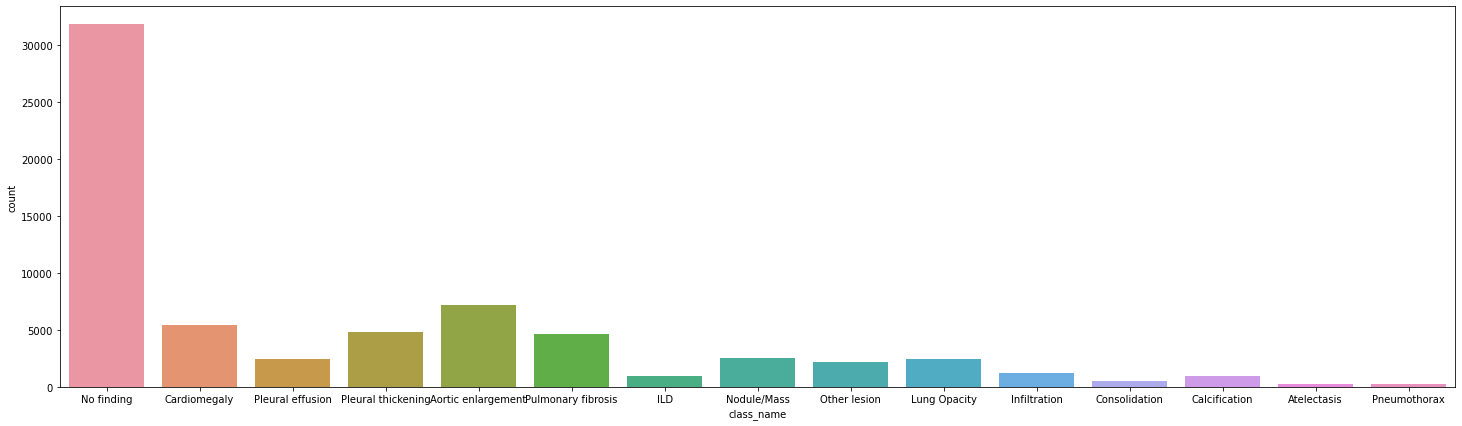

In [4]:
_, ax = plt.subplots(figsize=(25, 7))
sns.countplot(train_data["class_name"], ax=ax)

In [5]:
image_classes = train_data[["image_id", "class_name"]]
count_nofinding = image_classes[image_classes["class_name"] == "No finding"].groupby(["image_id"]).agg(["count"])
print(f"Total no finding: {len(count_nofinding)}")
count_nofind_disagree = count_nofinding[count_nofinding[("class_name", "count")] != 3]
print(f"Total no finding disagreements (not all 3 identified no find): {len(count_nofind_disagree)}")

Total no finding: 10606
Total no finding disagreements (not all 3 identified no find): 0


A large class imbalance towards "No finding", and there's no case where some radiologist would not find anything when others would.

## Stats for radiologists

### Count of labels for each radiologist (abnormal)

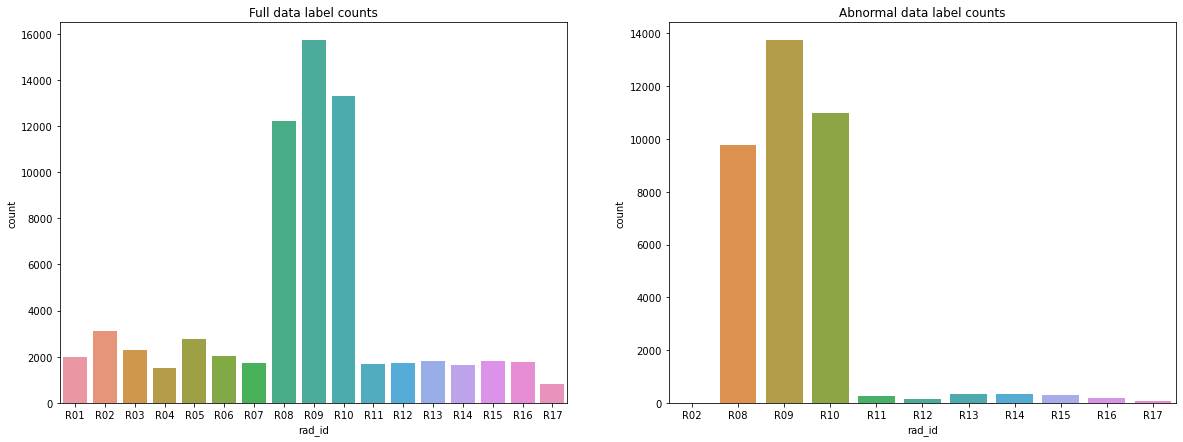

In [6]:
def plot_label_counts(ax, data, title):
    sns.countplot(data["rad_id"].sort_values(), ax=ax).set_title(title)

_, ax = plt.subplots(1, 2, figsize=(20, 7))
plot_label_counts(ax[0], train_data, "Full data label counts")
plot_label_counts(ax[1], train_data_abnormal, "Abnormal data label counts")

### Image counts for each radiologist (abnormal)

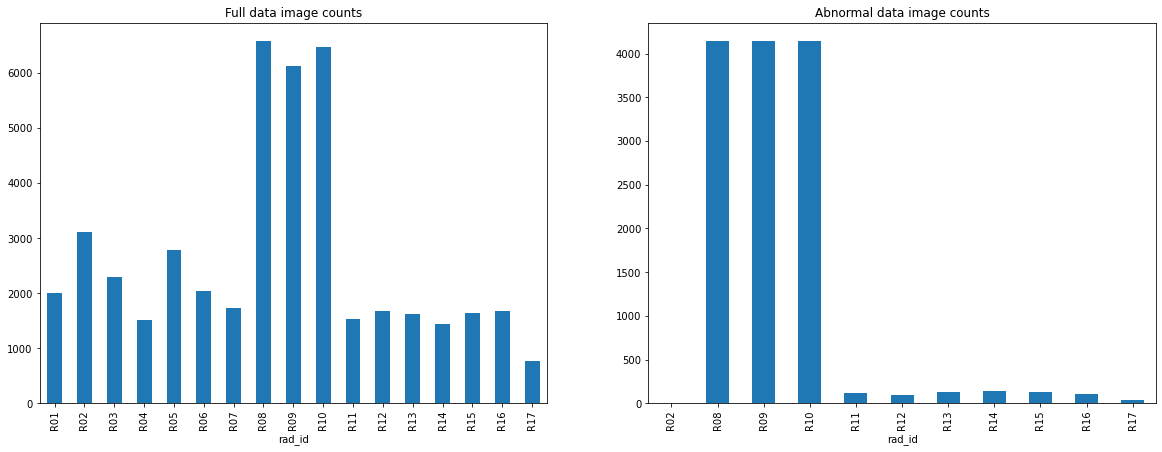

In [7]:
def plot_image_counts(ax, data, title):
    data = data[["image_id", "rad_id"]].groupby(["rad_id"]).image_id.nunique()
    data.sort_index().plot(kind="bar", ax=ax).set_title(title)

_, ax = plt.subplots(1, 2, figsize=(20, 7))
plot_image_counts(ax[0], train_data, "Full data image counts")
plot_image_counts(ax[1], train_data_abnormal, "Abnormal data image counts")

R9, R10, R8 all have 2x images labelled than the next highest labeller (R2), however, their label count is 4x higher than R2.

However, looking only at abnormal data, these three were labelling most of the abnormal data. Within abnormal data, R9 seems to have a bit more labels than the other two.

### Average label count per radiologist, per disease

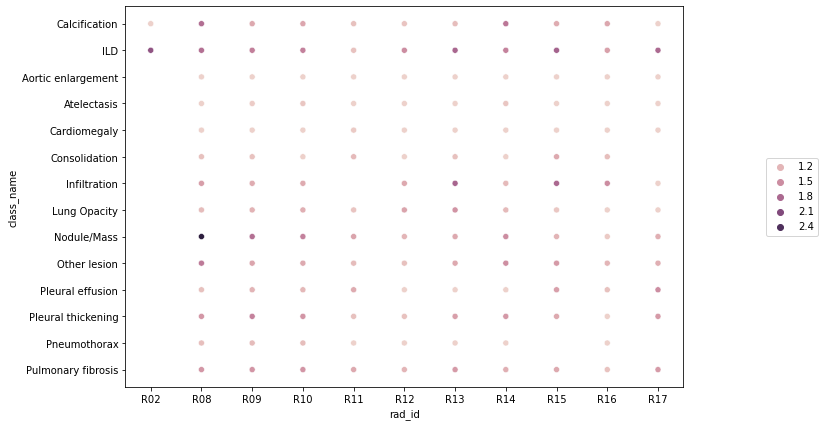

In [8]:
rad_stats_labels = train_data_abnormal[["image_id", "rad_id", "class_name"]]
rad_stats_labels = rad_stats_labels.groupby(["rad_id", "class_name"]).image_id.agg(lambda images: images.value_counts().mean())
_, ax = plt.subplots(figsize=(10, 7))
g = sns.scatterplot(data=rad_stats_labels.sort_index().reset_index(), x="rad_id", y="class_name", hue="image_id", ax=ax)
g.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)

R1, R3, R4, R5, R6, R7 only have labels "No finding". R2 only labelled 2 diseases (in addition to "No finding" labels).

R8 also seems to have abnormally large amount of labels per image for "Nodule/Mass" class.



### Who labels together

In [9]:
label_triplets = train_data[["rad_id", "image_id"]].groupby("image_id")["rad_id"].apply(lambda rads: ",".join(sorted(set(rads))))
label_triplets = label_triplets.reset_index().groupby(["rad_id"]).agg("count").sort_values(by="image_id", ascending=False)
label_triplets.head()

,image_id
rad_id,
"R08,R09,R10",5501
"R02,R03,R05",115
"R01,R02,R03",104
"R02,R03,R06",100
"R12,R13,R16",99


R8, R9, R10 seem to work together and labelled a lot of images together.

## Stats for diseases

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,dim0,dim1,bbox_size
34,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R15,161.0,56.0,2117.0,2213.0,2555,2285,0.722673
35,0c7a38f293d5f5e4846aa4ca6db4daf1,Other lesion,9,R15,161.0,56.0,2117.0,2213.0,2555,2285,0.722673
6946,6d5acf3f8a973a26844d617fffe72998,Nodule/Mass,8,R10,124.0,339.0,2238.0,2316.0,2880,2304,0.629849
10975,0d30dc1e0070e7a934f39452e3ad3b83,Other lesion,9,R09,43.0,29.0,2034.0,2327.0,2344,2080,0.938427
33178,e4a528876744e3a37158645935028c57,ILD,5,R17,112.0,387.0,1992.0,2444.0,2617,2093,0.706024


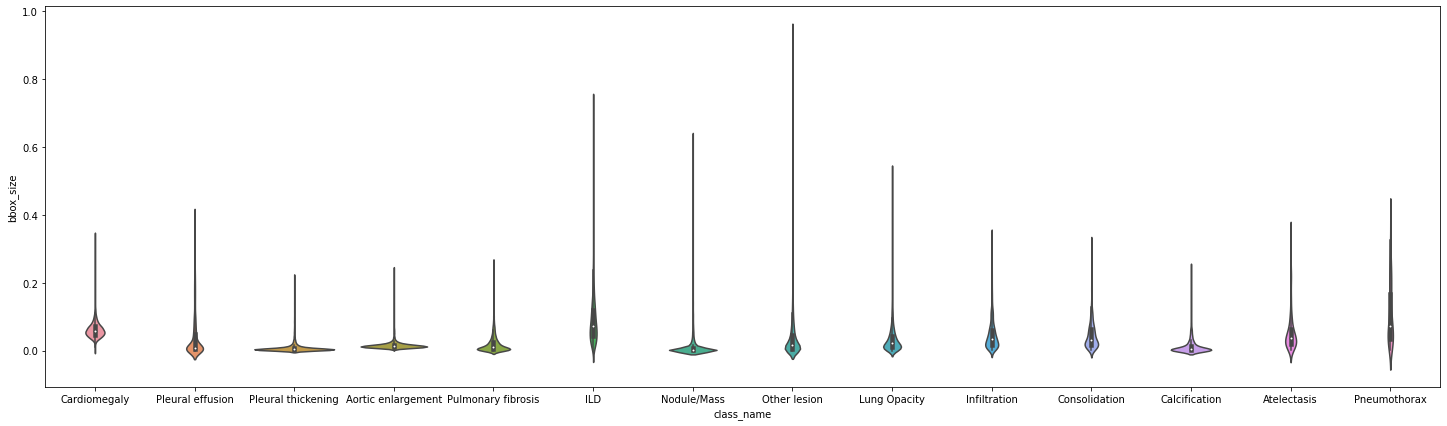

In [10]:
box_sizes = train_data_abnormal.copy()
box_sizes["bbox_size"] = (box_sizes["x_max"] - box_sizes["x_min"]) * (box_sizes["y_max"] - box_sizes["y_min"]) / (box_sizes["dim0"] * box_sizes["dim1"])
_, ax = plt.subplots(figsize=(25, 7))
sns.violinplot(data=box_sizes, x="class_name", y="bbox_size", ax=ax)
box_sizes[box_sizes["bbox_size"] > 0.6].head()

Seems like some of the diseases (ILD, Nodule/Mass, Other lesion) tend to have bbox sizes close to 1, so a radiologist could probably label the entire image containing small instances of the disease.

## Images exploration

In [11]:
TRAIN_IMAGES_DIR = os.path.join(INPUT_FOLDER, "train")
train_images = os.listdir(TRAIN_IMAGES_DIR)

In [12]:
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

def read_xray(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(data, dicom)

    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    
    data -= np.min(data)
    data /= np.max(data)
    data *= 255

    return data.astype(np.uint8)


In [13]:
from ipywidgets import interact
import ipywidgets as widgets

# dicom_metadata = pd.read_csv("vinbigdata-chest-xray-abnormalities-detection/dicomMetadata.csv")

@interact(im_idx=widgets.IntSlider(min=0, max=len(train_images)-1, step=1, value=0, continuous_update=False))
def display_xray(im_idx):
    image = read_xray(os.path.join(TRAIN_IMAGES_DIR, train_images[im_idx]))
    _, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image, "gray")

    # also display metadata alongside

interactive(children=(IntSlider(value=0, continuous_update=False, description='im_idx', max=9), Output()), _do…